In [37]:
import torch
import copy
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from models.my_fair import BinaryFair
from models.flow import Flow
from models.classifier import BinaryClassifier
from utils.StatisticalDistance import EmpiricalStatisticalDistance
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm.auto import trange
from utils.DataSplitting import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# TODO: Trim the fluff from this notebook and use new pipeline for everything
#Minimally working though which is great!

In [4]:
data_file = torch.load("data/Crime/data.pt")

In [5]:
# X_embedded = TSNE(n_components=2).fit_transform(data_file['data'])
# plt.scatter(*X_embedded.T, c=data_file['context'], alpha=0.07, cmap='coolwarm')

In [6]:
data = data_file['data']
context = data_file['context']
labels = data_file['labels']

In [7]:
data_train, data_test, context_train, context_test, labels_train, labels_test = train_test_split(data, context, labels, test_size=0.1)
data_train, data_val, context_train, context_val, labels_train, labels_val = train_test_split(data_train, context_train, labels_train, test_size=0.1)

In [8]:
# Parameters
params = {'batch_size': 64,
          'shuffle': True}

# Split data by label
data_0 = data_train[context_train.flatten()==0]
labels_0 = labels_train[context_train.flatten()==0]
context_0 = context_train[context_train.flatten()==0]

data_1 = data_train[context_train.flatten()==1]
labels_1 = labels_train[context_train.flatten()==1]
context_1 = context_train[context_train.flatten()==1]

data_0_test = data_test[context_test.flatten()==0]
labels_0_test = labels_test[context_test.flatten()==0]
context_0_test = context_test[context_test.flatten()==0]

data_1_test = data_test[context_test.flatten()==1]
labels_1_test = labels_test[context_test.flatten()==1]
context_1_test = context_test[context_test.flatten()==1]

data_0_val = data_val[context_val.flatten()==0]
labels_0_val = labels_val[context_val.flatten()==0]
context_0_val = context_val[context_val.flatten()==0]

data_1_val = data_val[context_val.flatten()==1]
labels_1_val = labels_val[context_val.flatten()==1]
context_1_val = context_val[context_val.flatten()==1]

# Generators
label_0_set = TensorDataset(data_0, labels_0, context_0)
label_0_generator = torch.utils.data.DataLoader(label_0_set, **params)

label_1_set = TensorDataset(data_1, labels_1, context_1)
label_1_generator = torch.utils.data.DataLoader(label_1_set, **params)

label_0_set_test = TensorDataset(data_0_test, labels_0_test, context_0_test)
label_0_generator_test = torch.utils.data.DataLoader(label_0_set_test, **params)

label_1_set_test = TensorDataset(data_1_test, labels_1_test, context_1_test)
label_1_generator_test = torch.utils.data.DataLoader(label_1_set_test, **params)

label_0_set_val = TensorDataset(data_0_val, labels_0_val, context_0_val)
label_0_generator_val = torch.utils.data.DataLoader(label_0_set_val, **params)

label_1_set_val = TensorDataset(data_1_val, labels_1_val, context_1_val)
label_1_generator_val = torch.utils.data.DataLoader(label_1_set_val, **params)



In [9]:
# Parameters
params = {'batch_size': 64,
          'shuffle': True}

# Generators
data_set_train = TensorDataset(data_train, context_train)
data_generator_train = torch.utils.data.DataLoader(data_set_train, **params)

data_set_test = TensorDataset(data_test, context_test)
data_generator_test = torch.utils.data.DataLoader(data_set_test, **params)

data_set_val = TensorDataset(data_val, context_val)
data_generator_val = torch.utils.data.DataLoader(data_set_val, **params)

In [47]:
data_set_labels_train = TensorDataset(data_train, labels_train.squeeze()) #For label classifier, use data and labels but not context
data_generator_labels_train = torch.utils.data.DataLoader(data_set_labels_train, **params)

data_set_context_train = TensorDataset(data_train, context_train.squeeze()) #For adversairal classifier, use data and context but not labels
data_generator_context_train = torch.utils.data.DataLoader(data_set_context_train, **params)

label_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
label_classifier.fit(data_generator_labels_train)

adversarial_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
adversarial_classifier.fit(data_generator_context_train)

baseline_label_acc = label_classifier.accuracy(data_test, labels_test.squeeze())
adv_acc = adversarial_classifier.accuracy(data_test, context_test.squeeze())

print("Label accuracy:", baseline_label_acc, "Adversarial accuracy:", adv_acc)


100%|██████████| 10000/10000 [00:12<00:00, 815.92it/s]

Label accuracy: 0.8149999976158142 Adversarial accuracy: 0.9700000286102295


In [10]:
probability_flow = Flow(data_dim=data_train.shape[-1], 
                  context_dim=context_train.shape[-1],
                  n_layers = 3,
                  transform_type = 'MaskedAffineAutoregressiveTransform', 
        )
optimizer = torch.optim.AdamW(probability_flow.parameters(), lr=1e-3, weight_decay=1e-4)

In [11]:
n_steps_prob = 2000
num_epochs = 5
probability_loss = []
best_params = probability_flow.state_dict()
best_loss_val = np.inf

probability_flow.train()
for n_step in trange(n_steps_prob):
    data, context = next(iter(data_generator_train))
    
    optimizer.zero_grad()

    loss = -probability_flow.log_prob(inputs=data, context=context).mean()
    probability_loss.append(loss.item())

    if (n_step+1) % (n_steps_prob/num_epochs) == 0:
        print(n_step)
        data_val, context_val = next(iter(data_generator_val))
        loss_val = -probability_flow.log_prob(inputs=data_val, context=context_val).mean()
        if loss_val.item() < best_loss_val:
            best_loss_val = loss_val.item()
            best_params = copy.deepcopy(probability_flow.state_dict())
            print(best_loss_val)

    loss.backward()
    optimizer.step()
probability_flow.eval();
probability_flow.load_state_dict(best_params)

 21%|██        | 424/2000 [00:01<00:06, 231.67it/s]

399
-4.262903213500977


 41%|████▏     | 826/2000 [00:03<00:05, 220.87it/s]

799
-4.8263773918151855


 61%|██████▏   | 1229/2000 [00:05<00:03, 235.02it/s]

1199


 82%|████████▏ | 1638/2000 [00:07<00:01, 233.00it/s]

1599
-5.0762763023376465


100%|██████████| 2000/2000 [00:08<00:00, 230.55it/s]

1999


<All keys matched successfully>

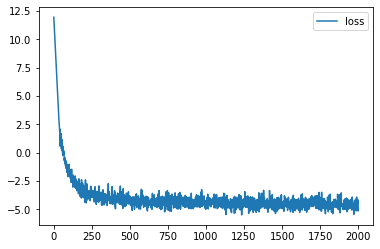

In [11]:
plt.plot(probability_loss, label="loss")
xlims = plt.xlim()
ylims = plt.ylim()
plt.legend()
plt.show()

In [ ]:
# data, context = next(iter(data_generator_test))
# data_embedded = TSNE(n_components=2).fit_transform(data)
# samples = probability_flow._sample(num_samples=1, context=context)

# catData = torch.cat((data, samples.squeeze(dim=1)))
# catData_embedded = TSNE(n_components=2).fit_transform(catData.detach().numpy())
# catLabel = torch.cat((torch.zeros(data.shape[0]), torch.ones(samples.shape[0])))

# plt.scatter(*catData_embedded.T, c=catLabel, alpha=0.1, cmap='coolwarm')

In [12]:
gamma = 0.5
Fair = BinaryFair(data_dim=data_train.shape[-1], 
                    context_dim=context_train.shape[-1],
                    flow_n_layers = 2,
                    flow_transform_type = 'MaskedPiecewiseQuadraticAutoregressiveTransform', 
                    classifier_hidden_dim = 32,
                    classifier_n_layers = 2,
                    classifier_activation = 'ReLU',
                    num_bins = 50,
                    tails='linear',
                    tail_bound=6.0,
                    gamma=gamma
                    )
optimizer = torch.optim.AdamW(Fair.parameters(), lr=1e-4, weight_decay=1e-4)
total_losses = []
KL_losses = []
clf_losses = []

In [13]:
# ! gamma != 0 is giving nan embeddings and transforms when training for a long time
# Todo add validation to .fit
fair_loss = Fair.fit(label_0_generator, label_1_generator, probability_flow, n_steps=4000)

100%|██████████| 4000/4000 [15:24<00:00,  4.33it/s]


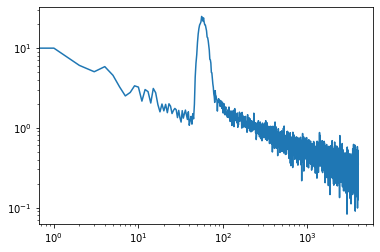

In [98]:
plt.plot(fair_loss, label="fair loss")
plt.xscale('log')
plt.yscale('log')

In [ ]:
# n_steps = 100
# num_epochs = 5
# best_params_fair = Fair.state_dict()
# best_loss_val = np.inf

# Fair.train()
# for n_step in trange(n_steps):
#     data_0, labels_0, context_0 = next(iter(label_0_generator))
#     data_1, labels_1, context_1 = next(iter(label_1_generator))
    
#     optimizer.zero_grad()

#     L_KL, L_clf, loss = Fair.loss(data_0, data_1, labels_0=labels_0, labels_1=labels_1, context_0=context_0, context_1=context_1, return_all_losses=True, probability_flow=probability_flow)

#     total_losses.append(loss.item())
#     KL_losses.append(L_KL.item())
#     clf_losses.append(L_clf.item())

#     if (n_step + 1) % (n_steps / num_epochs) == 0:
#         data_0_val, labels_0_val, context_0_val = next(iter(label_0_generator_val))
#         data_1_val, labels_1_val, context_1_val = next(iter(label_1_generator_val))
#         _, _, loss_val = Fair.loss(data_0_val, data_1_val, labels_0=labels_0_val, labels_1=labels_1_val, context_0=context_0_val, context_1=context_1_val, return_all_losses=True, probability_flow=probability_flow)
#         if loss_val.item() < best_loss_val:
#             best_loss_val = loss_val.item()
#             best_params_fair = copy.deepcopy(Fair.state_dict())
#             print(best_loss_val)

#     loss.backward()
#     optimizer.step()
# Fair.eval();
# Fair.load_state_dict(best_params_fair)

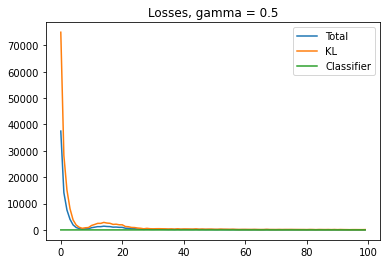

In [ ]:
plt.plot(total_losses, label="Total")
xlims = plt.xlim()
ylims = plt.ylim()
plt.plot(KL_losses, label="KL")
plt.plot(clf_losses, label="Classifier")
plt.legend()
plt.xlim(*xlims)
# plt.ylim(-10,20)
plt.title("Losses, gamma = " + str(gamma))
# plt.savefig("Figures/losses_gamma_" + str(gamma) + ".png")
plt.show()

Text(0.5, 1.0, 'Embedding, gamma = 0.5')

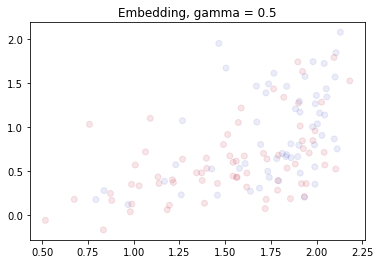

In [99]:
data_0, labels_0, context_0 = next(iter(label_0_generator))
data_1, labels_1, context_1 = next(iter(label_1_generator))

embedding_0, embedding_1 = Fair._embed(data_0, data_1, context_0=context_0, context_1=context_1)

plt.scatter(*embedding_0.T[0:2].detach(), alpha=0.1, c=labels_0, cmap='coolwarm')
plt.scatter(*embedding_1.T[0:2].detach(), alpha=0.1, c=labels_1, cmap='coolwarm')

plt.title("Embedding, gamma = " + str(gamma))
# plt.savefig("Figures/embedding_gamma_" + str(gamma) + ".png")

Text(0.5, 1.0, 'Embedding, gamma = 0.0')

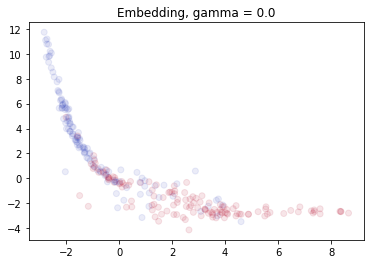

In [ ]:
data_0, labels_0, _ = next(iter(label_0_generator))
data_1, labels_1, _ = next(iter(label_1_generator))

embedding_0, embedding_1 = Fair._embed(data_0, data_1, context_0=None, context_1=None)

plt.scatter(*embedding_0.T[0:2].detach(), alpha=0.1, c=labels_0, cmap='coolwarm')
plt.scatter(*embedding_1.T[0:2].detach(), alpha=0.1, c=labels_1, cmap='coolwarm')

plt.title("Embedding, gamma = " + str(gamma))
# plt.savefig("Figures/embedding_gamma_" + str(gamma) + ".png")

In [ ]:
with torch.no_grad():
    cont_pred = Fair(data_file['data'], data_file['context'])
    bin_pred = (cont_pred > 0.5).int()
    acc = accuracy_score(bin_pred, data_file['labels'])
acc

0.8350050150451354

Accuracies:
    gamma = 0. : 0.84  # paper achieves 85.2 (not too far off)
    gamma = 1. : 0.5

/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


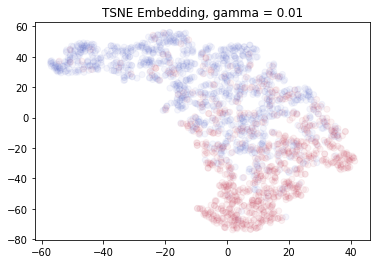

In [ ]:
# #Interpreting the representations
# with torch.no_grad():
#     idx = (data_file["context"] == 0).flatten()
#     data_0 = data_file["data"][idx]
#     data_1 = data_file["data"][~idx]

#     # x0 = probability_flow.sample(num_samples=1, context=data_file["context"][idx]).squeeze()
#     # x1 = probability_flow.sample(num_samples=1, context=data_file["context"][~idx]).squeeze()

#     embedding_0, embedding_1 = Fair._fair_embed(
#         x0=data_0, x1=data_1
#     )
#     embedding = torch.cat([data_0, embedding_0])
#     X_embedded = TSNE(n_components=2).fit_transform(embedding)
# embed_labels = torch.cat([torch.zeros(data_0.shape[0]), torch.ones(embedding_0.shape[0])])
# plt.scatter(*X_embedded.T, c=embed_labels, alpha=0.05, cmap="coolwarm")
# plt.title("TSNE Embedding, gamma = " + str(gamma))
# plt.savefig("Figures/tsne_clustering_gamma_" + str(gamma) + ".png")

For gamma = 1, these two should be on top of one another, but they're not!

In [15]:
with torch.no_grad():
    idx = (data_file["context"] == 0).flatten()
    
    embedding_0, embedding_1 = Fair._embed(
        data_file["data"][idx], data_file["data"][~idx], context_0=data_file["context"][idx], context_1=data_file["context"][~idx]
    )

EmpiricalStatisticalDistance(
    embedding_0, embedding_1, hidden_dim=64, n_layers=5, n_epochs=100
)


100%|██████████| 100/100 [00:04<00:00, 21.47it/s]

Training set accuracy: 0.620
Test set accuracy: 0.590


0.590047393364929

In [20]:
#Optimal Adversary
#TODO: need to add the context to the data
# idx = (data_file["context"] == 0).flatten()
# data_0 = data_file["data"][idx]
# data_1 = data_file["data"][~idx]
# context_0 = data_file["context"][idx]
# context_1 = data_file["context"][~idx]
data_0, labels_0, context_0 = next(iter(label_0_generator))
data_1, labels_1, context_1 = next(iter(label_1_generator))

# mu_star_0_avg, mu_star_1_avg, stat_dist, logP_Z0_z0, logP_Z1_z1, logP_Z0_z1, logP_Z1_z0 = Fair.optimal_adversary(data_0, data_1, context_0=context_0, context_1=context_1, probability_flow=probability_flow)
stat_dist, mu_star_0, mu_star_1, = Fair.optimal_adversary(label_0_generator, label_1_generator, probability_func=probability_flow)


gamma: 0.01 mu_star_0_avg: tensor(0.1875) mu_star_1_ave: tensor(0.8750) stat_dist: tensor(-0.6875)

gamma: 0.9 mu_star_0_avg: tensor(0.2812) mu_star_1_ave: tensor(0.5938) stat_dist: tensor(-0.3125)

In [24]:
gammas = [0.0, 0.02, 0.1, 0.2, 0.9]
Fairs = []

In [25]:
for gamma in gammas:
    Fair = BinaryFair(data_dim=data_train.shape[-1], 
                    context_dim=context_train.shape[-1],
                    flow_n_layers = 2,
                    flow_transform_type = 'MaskedPiecewiseQuadraticAutoregressiveTransform', 
                    classifier_hidden_dim = 32,
                    classifier_n_layers = 2,
                    classifier_activation = 'ReLU',
                    num_bins = 50,
                    tails='linear',
                    tail_bound=6.0,
                    gamma=gamma
                    )
    fair_loss = Fair.fit(label_0_generator, label_1_generator, probability_flow, n_steps=1000)

    Fairs.append(Fair)


100%|██████████| 1000/1000 [04:02<00:00,  4.12it/s]


In [27]:
data_0_test, labels_0_test, context_0_test = next(iter(label_0_generator_test))
data_1_test, labels_1_test, context_1_test = next(iter(label_1_generator_test))
stat_dists=[]
mu0s_arr=[]
mu1s_arr=[]

for fair in Fairs:
    stat_dist, mu0s, mu1s = fair.optimal_adversary(label_0_generator_test, label_1_generator_test,probability_func=probability_flow)
    mu0s_arr.append(mu0s.sum().item()/len(mu0s))
    mu1s_arr.append(mu1s.sum().item()/len(mu1s))
    stat_dists.append(abs(stat_dist.item()))
print(stat_dists)

[1.0, 0.59375, 0.484375, 0.234375, 0.28125]


In [ ]:
data_0_test, labels_0_test, context_0_test = next(iter(label_0_generator_test))
data_1_test, labels_1_test, context_1_test = next(iter(label_1_generator_test))
stat_dists=[]
mu0s_arr=[]
mu1s_arr=[]

for fair in Fairs:
    stat_dist, mu0s, mu1s = fair.optimal_adversary(data_0_test, data_1_test, context_0=context_0_test, context_1=context_1_test, probability_flow=probability_flow)
    mu0s_arr.append(mu0s.sum().item()/len(mu0s))
    mu1s_arr.append(mu1s.sum().item()/len(mu1s))
    stat_dists.append(abs(stat_dist.item()))
print(stat_dists)

[0.8125, 0.3203125, 0.1484375, 0.109375]


In [28]:
with torch.no_grad():
    idx = (data_file["context"] == 0).flatten()
    embedding_0, embedding_1 = Fair._embed(
        data_file["data"][idx], data_file["data"][~idx], context_0=data_file["context"][idx], context_1=data_file["context"][~idx])

acc_test = EmpiricalStatisticalDistance(
    embedding_0, embedding_1, hidden_dim=64, n_layers=5, n_epochs=100, report_accuracy=True
)

100%|██████████| 100/100 [00:04<00:00, 21.36it/s]

Training set accuracy: 0.610
Test set accuracy: 0.581


In [ ]:
accs = []
for fair in Fairs:
    with torch.no_grad():
        idx = (data_file["context"] == 0).flatten()
        embedding_0, embedding_1 = fair._embed(
            data_file["data"][idx], data_file["data"][~idx], context_0=data_file["context"][idx], context_1=data_file["context"][~idx])

    acc_test = EmpiricalStatisticalDistance(
        embedding_0, embedding_1, hidden_dim=64, n_layers=5, n_epochs=100, report_accuracy=True
    )
    accs.append(acc_test)

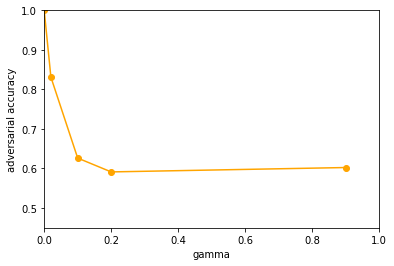

In [33]:
plt.plot(gammas, accs, '-o', color='orange')
plt.xlim(0,1)
plt.ylim(0.45,1)
plt.xlabel('gamma')
plt.ylabel('adversarial accuracy')
plt.show()

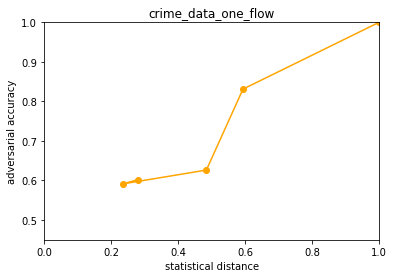

In [36]:
plt.plot(stat_dists, accs, '-o', color='orange')
plt.xlim(0,1)
plt.ylim(0.45,1)
plt.xlabel('statistical distance')
plt.ylabel('adversarial accuracy')
plt.title('crime_data_one_flow')
plt.savefig('crime_data_one_flow.png')
plt.show()


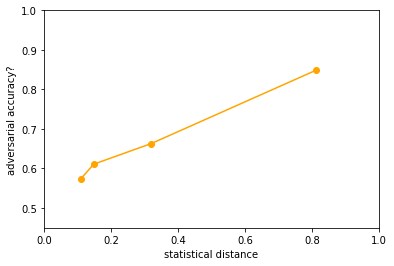

In [ ]:
plt.plot(stat_dists, accs, '-o', color='orange')
plt.xlim(0,1)
plt.ylim(0.45,1)
plt.xlabel('statistical distance')
plt.ylabel('adversarial accuracy?')
plt.show()

add validation set (both to probability flow and FAIR)
85, 10, 5

Check classifier accuracy (separate generation from analysis)
torch.save model
torch.load model
rewrite splitting
save probability flow separately

In [43]:
embedded_label_accs = []
adversary_accs = []
for fair in Fairs:

    embedding_context_generator, embedding_labels_generator, embedding_data_test, embedding_context_test, embedding_labels_test = get_embedding_data(data_train, labels_train.squeeze(), context_train.squeeze(), data_test, labels_test.squeeze(), context_test.squeeze(), fair)

    adv_classifier = BinaryClassifier(data_dim=data_train.shape[-1])    
    adv_classifier.fit(embedding_context_generator)
    embedded_label_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
    embedded_label_classifier.fit(embedding_labels_generator)

    embedded_label_accs.append(embedded_label_classifier.accuracy(embedding_data_test, embedding_labels_test))
    adversary_accs.append(adv_classifier.accuracy(embedding_data_test, embedding_context_test))

100%|██████████| 10000/10000 [00:12<00:00, 823.76it/s]


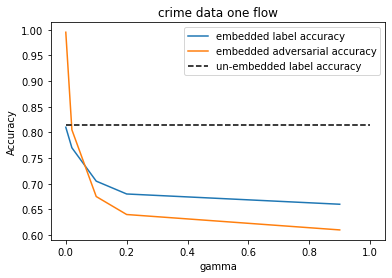

In [51]:
plt.plot(gammas, embedded_label_accs, label='embedded label accuracy')
plt.plot(gammas, adversary_accs, label='embedded adversarial accuracy')
plt.plot(np.linspace(0,1,10),np.ones(10)*baseline_label_acc, 'k--', label='un-embedded label accuracy')


plt.xlabel('gamma')
plt.ylabel('Accuracy')
plt.title('crime data one flow')
plt.legend()
# plt.savefig('single_flow_crime_accuracy.png')
plt.show()